
# Задание:
----

<br>

Вам предоставлен анонимизированные результаты **реального A/B тестирования**, проходившего когда-то в нашем отделе (`ab_test_ensembles.csv`). В тесте было два варианта работы сервиса - `standard` и `svm_ensemble_v_1_22`, где работали несколько моделей классификации для целей сервиса.

<br>


------
Вам, как специалистам по машинному обучению предстоит ответить на **2 главных вопроса:**

1. Стоит ли нам оставить старый вариант работы сервиса или заменить его на вариант работы с моделями классификации (используем всю выборку 200к+ пользователей).
2. Кроме того, посчитайте вывод для типа пользователей (`user_type`). Стоит ли для новых (старых) пользователей оставить старый (новый) вариант работы сервиса.


<br>

Для того, чтобы освежить в памяти процесс тестирования статистических гипотез, непомню, что тестирование состоит из следующих частей:
1. Дизайн эксперимента.
2. Подготовка и запуск эксперимента.
3. Сбор данных и аналитика полученных данных.
4. Визуализация результатов тестирования.
5. Тестирование гипотез.
6. Вывод и интерпритация результатов.

-----

#### Критерии оценки задания:

1. **Первое, что будет проверяться - вывод полученных результатов**, в случае если выводы сделаны не правильно, задание считается проваленным и на этом этап проверки заканчивается (пропускаются этапы код-ревью, оформления и визуализации, качество кода).
2. В случае если результаты и интерпритация результатов оказались верны, проводится код-ревью и проверка этапа визуализаций, поиск проблемных точек, точек роста.
3. **Максимальный балл** который можно получить, выполнив текущее задание: **2 балла за 1 вопрос, 2 балла за 2 вопрос и 1 балл за эффективный и аккуратный код.


Удачи, примените все свои навыки, которые вам доступны на данный момент и покажите на что вы способны!

In [1]:
import pandas as pd
import numpy as np
import pylab
from scipy.stats import stats, norm, binom, beta, normaltest, probplot
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
np.random.seed(42)

<div align="center"> <font size="5"> <b>A/B testing all data</b> </div>

In [2]:
data = pd.read_csv('ab_test_ensembles.csv')

In [3]:
data.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


In [5]:
data.dtypes

user_id      object
timestamp    object
group        object
variants     object
converted     int64
location     object
age_group    object
user_type    object
dtype: object

In [6]:
data.columns

Index(['user_id', 'timestamp', 'group', 'variants', 'converted', 'location',
       'age_group', 'user_type'],
      dtype='object')

In [7]:
data['timestamp']=pd.to_datetime(data['timestamp'])

In [8]:
data.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,294478,2022-05-13 13:40:10.474213120,2022-05-02 13:42:05.378582,2022-05-08 02:06:48.649925120,2022-05-13 13:21:07.016475904,2022-05-19 01:43:51.611873792,2022-05-24 13:41:54.460509,NaN
converted,294478.0,0.119659,0.0,0.0,0.0,0.0,1.0,0.324563


In [9]:
data.isnull().sum()

user_id      0
timestamp    0
group        0
variants     0
converted    0
location     0
age_group    0
user_type    0
dtype: int64

In [10]:
data[(data['variants'] == 'standard') & (data['group']!='control')]

,user_id,timestamp,group,variants,converted,location,age_group,user_type
308,e0a7ff8a-5b2f-414d-94c2-0d8a22e3e75f,2022-05-20 07:34:59.832626,treatment,standard,0,United Kingdom,34-41,new_user
327,ea444dd3-bb3b-43ba-89d8-becacce46186,2022-05-09 14:26:40.734775,treatment,standard,0,United Kingdom,18-25,new_user
357,67151f1f-c458-4c3e-ad23-34c659a32dc1,2022-05-12 12:29:30.354835,treatment,standard,0,United Kingdom,18-25,registered_user
685,f334e08f-2988-4c7a-af51-bb9cee5a87c4,2022-05-23 08:11:54.823806,treatment,standard,0,United Kingdom,26-33,registered_user
713,9b926e28-dc2a-40e1-88e3-d5c77b7ad54f,2022-05-10 15:47:44.445196,treatment,standard,0,United Kingdom,34-41,new_user
...,...,...,...,...,...,...,...,...
293773,7b8ecf7c-6fa2-46fc-8e11-134c47fabf85,2022-05-16 20:34:50.450528,treatment,standard,1,United Kingdom,50-57,new_user
293817,df343f17-8ba4-455d-8c7d-63f4e422bca7,2022-05-17 16:15:08.957152,treatment,standard,1,United Kingdom,34-41,new_user
293917,e4b6be16-af98-4761-a76a-33dc04c3d295,2022-05-05 15:37:55.729133,treatment,standard,0,United Kingdom,50-57,registered_user
294014,61b6e764-d6d5-42d2-aac2-9dee89e1af54,2022-05-09 06:25:33.223301,treatment,standard,0,United Kingdom,26-33,registered_user


In [11]:
data.loc[(data['variants'] == 'standard') & (data['group']!='control'),'group'] = 'control'

In [12]:
data[(data['variants'] == 'svm_ensemble_v_1_22')&(data['group']!='treatment')]

,user_id,timestamp,group,variants,converted,location,age_group,user_type
22,74c0de1f-fe1d-46d8-8c46-e2111df72209,2022-05-12 22:58:14.991443,control,svm_ensemble_v_1_22,0,United Kingdom,18-25,new_user
240,5fdfbb62-0223-42d9-ba75-98670ff5dc57,2022-05-11 15:11:16.407599,control,svm_ensemble_v_1_22,0,United Kingdom,34-41,new_user
490,8f5792f5-46ee-4d72-a5c5-00fc2bddcdb1,2022-05-10 21:44:01.292755,control,svm_ensemble_v_1_22,0,United Kingdom,50-57,new_user
846,461308d4-9391-41be-85c2-4cc33fc9c06f,2022-05-11 23:09:52.682329,control,svm_ensemble_v_1_22,1,United Kingdom,58+,registered_user
850,2a9f28e3-0bea-4ec2-bbe9-d78c5ec9c8c8,2022-05-08 03:25:33.723712,control,svm_ensemble_v_1_22,1,United Kingdom,42-49,registered_user
...,...,...,...,...,...,...,...,...
293894,0c56347e-4d4e-471d-8aba-d246f9d5cd4b,2022-05-09 20:49:03.391764,control,svm_ensemble_v_1_22,0,United Kingdom,58+,new_user
293996,ae5a82bd-1313-4400-a620-ec3d1f68623f,2022-05-08 13:52:28.182648,control,svm_ensemble_v_1_22,0,United Kingdom,42-49,new_user
294200,c2ea5a8e-d16c-486b-aa6a-a9a7b6b53218,2022-05-13 21:32:10.491309,control,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
294253,0b7c40ba-24c8-49e6-8eb9-4e47679efc48,2022-05-06 12:49:20.509403,control,svm_ensemble_v_1_22,0,United Kingdom,34-41,registered_user


In [13]:
data.loc[(data['variants'] == 'svm_ensemble_v_1_22')&(data['group']!='treatment'),'group'] = 'treatment'

In [14]:
data[['variants']].value_counts()

variants           
standard               147239
svm_ensemble_v_1_22    147239
Name: count, dtype: int64

In [15]:
data[['group']].value_counts()

group    
control      147239
treatment    147239
Name: count, dtype: int64

In [16]:
data['converted'].value_counts()

converted
0    259241
1     35237
Name: count, dtype: int64

In [17]:
data['user_type'].value_counts(normalize=True)

user_type
registered_user    0.500003
new_user           0.499997
Name: proportion, dtype: float64

In [18]:
pd.pivot_table(data,index=['user_type','variants'],values='converted',aggfunc=np.mean)

converted
user_type       variants                      
new_user        standard              0.121075
                svm_ensemble_v_1_22   0.117223
registered_user standard              0.119877
                svm_ensemble_v_1_22   0.120450

In [20]:
data.groupby('variants')['converted'].agg(['sum','mean','max','min'])


,sum,mean,max,min
variants,,,,
standard,17739,0.120478,1,0
svm_ensemble_v_1_22,17498,0.118841,1,0


- The data is distributed evenly between Sample A and B

- The mean converted values for A - 0.12 and for B - 0.118

((array([-4.57741243, -4.38824339, -4.2856733 , ...,  4.2856733 ,
          4.38824339,  4.57741243]),
  array([0, 0, 0, ..., 1, 1, 1])),
 (0.19964378104848943, 0.11965919355605509, 0.6151064839133327))

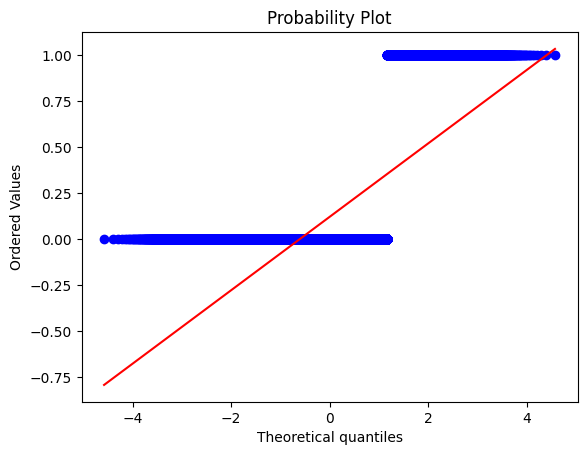

In [21]:
import pylab
probplot(data['converted'], dist='norm', plot=pylab)

<Axes: >

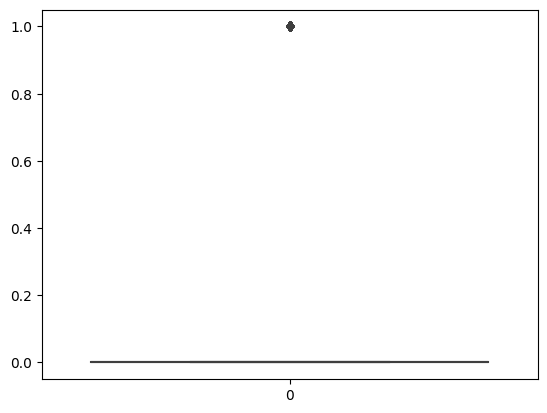

In [22]:
sns.boxplot(data['converted'])

<Axes: xlabel='converted', ylabel='Density'>

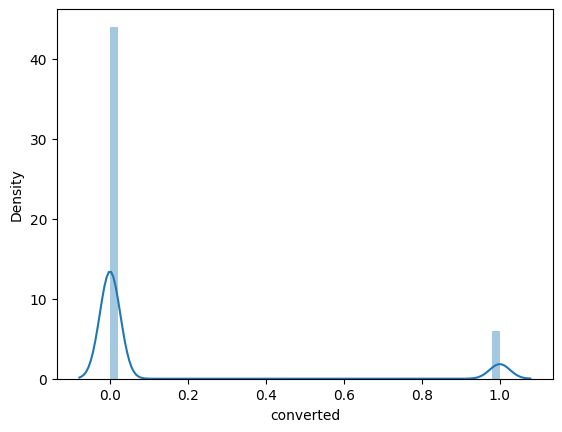

In [23]:
sns.distplot(data['converted'])

In [24]:
from scipy.stats import kstest

def k_stest(data):
  stat, p = kstest(data,'norm')
  print('Stat = %.3f, p = %.3f\n' %(stat, p ))
  if p >0.05:
    print("Probably Gaussian")
  else:
    print("Probably Not Gaussian\n")

k_stest(data['converted'])

Stat = 0.500, p = 0.000

Probably Not Gaussian



<b>The data takes discrete values. Statistical tests and visualization also showed a non-Gaussian distribution</b>

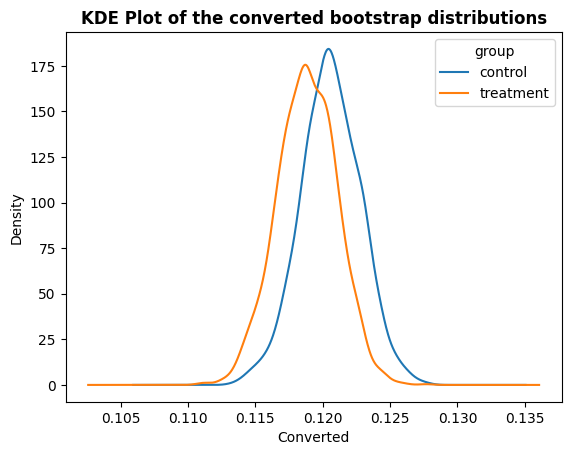

In [25]:
n = 2000

bootstrap_sum = pd.DataFrame([data.sample(frac=0.15, replace=True).groupby('group')['converted'].mean() for i in range(n)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the converted bootstrap distributions", fontweight="bold")
plt.xlabel("Converted")
plt.show()

In [26]:
bootstrap_sum['diff_mean'] = bootstrap_sum['treatment'] - bootstrap_sum['control']
mean_pos_count = len(bootstrap_sum[bootstrap_sum['diff_mean'] > 0])
p_mean_diff = mean_pos_count/n
p_mean_diff

0.286

In [27]:
alpha = 0.05
z_mean = np.mean(bootstrap_sum['treatment'])- np.mean(bootstrap_sum['control'])
z_sigma = np.sqrt((np.var(bootstrap_sum['treatment'])/n + np.var(bootstrap_sum['control'])/n))
print("Mean of (treatment - control):\t\t", z_mean)
print("Standard Error of (treatment -  control):", z_sigma)
print("CI of (treatment - control):\t\t", [z_mean - norm.ppf(1-alpha/2)*z_sigma, z_mean + norm.ppf(1-alpha/2)*z_sigma] )

Mean of (treatment - control):		 -0.0017491848297594564
Standard Error of (treatment -  control): 7.011102029591093e-05
CI of (treatment - control):		 [-0.0018865999044587985, -0.0016117697550601144]


In [28]:
np.percentile(bootstrap_sum['diff_mean'], [2.5, 97.5])

array([-0.00784314,  0.00447715])

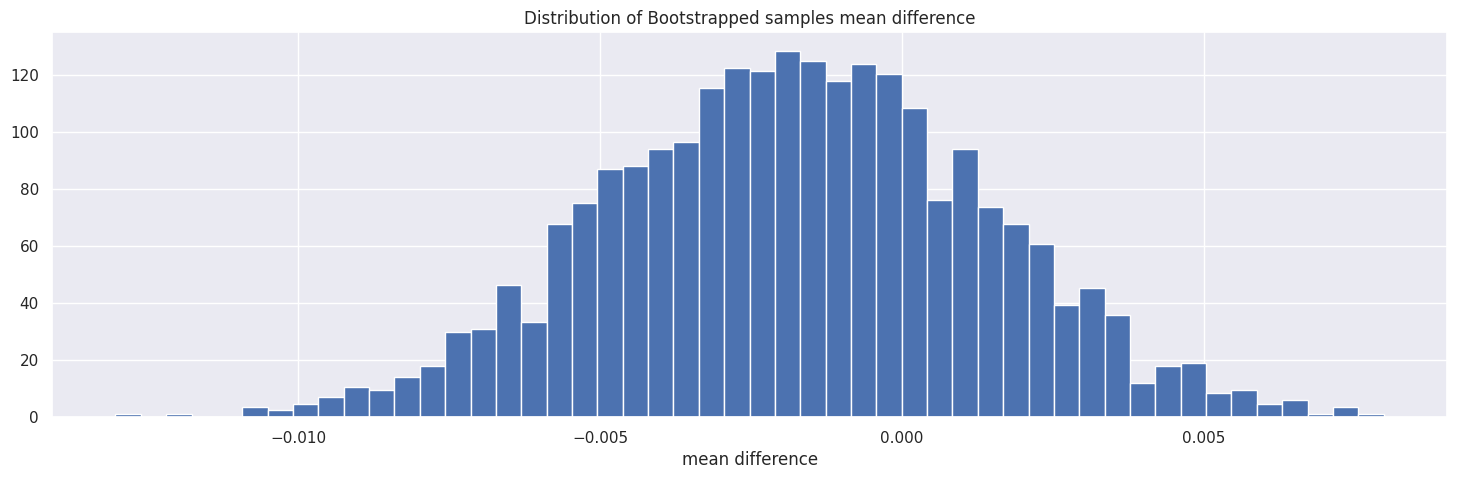

In [30]:
counts,bins,ignored = plt.hist(bootstrap_sum['diff_mean'],50,density = True)
plt.xlabel("mean difference")
plt.title("Distribution of Bootstrapped samples mean difference")
plt.show()

In [31]:
"""
Distribution of new users by control and treatment
"""
data[data['user_type'] == 'new_user'].groupby('group')['converted'].sum()/data[data['user_type'] == 'new_user'].groupby('group')['converted'].count()*100

group
control      12.107538
treatment    11.722335
Name: converted, dtype: float64

In [32]:
"""
Distribution of registered_user users by control and treatment
"""
data[data['user_type'] == 'registered_user'].groupby('group')['converted'].sum()/data[data['user_type'] == 'registered_user'].groupby('group')['converted'].count()*100

group
control      11.987691
treatment    12.045042
Name: converted, dtype: float64

In [33]:
pd.pivot_table(data[data['user_type'] == 'new_user'],index ='group',values='converted',aggfunc = np.mean)

,converted
group,
control,0.121075
treatment,0.117223


In [34]:
pd.pivot_table(data[data['user_type'] == 'registered_user'],index ='group',values='converted',aggfunc = np.mean)

,converted
group,
control,0.119877
treatment,0.120450


- For new users in control group , the value is higher than in treatment group 
- For registered users, on the contrary, the treatment value is better than the control value

In [35]:
from scipy.stats import chi2_contingency

def chi2_con_test(data):
    chi2, p, dof, ex = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two verisions have no significant difference')
    else:
        print('Two verisions have a significant difference')

In [36]:
data_all = pd.crosstab(data['group'],data['converted'])
data_new = pd.crosstab(data[data['user_type'] == 'new_user']['group'],data[data['user_type'] == 'new_user']['converted'])
data_registered = pd.crosstab(data[data['user_type'] == 'registered_user']['group'],data[data['user_type'] == 'registered_user']['converted'])

In [37]:
print('For all users')
chi2_con_test(data_all)

print('\nFor new users')
chi2_con_test(data_new)

print('\nFor registered users')
chi2_con_test(data_registered)

For all users
p=0.1730 , alpha=0.05 
Two verisions have no significant difference

For new users
p=0.0230 , alpha=0.05 
Two verisions have a significant difference

For registered users
p=0.7411 , alpha=0.05 
Two verisions have no significant difference


- Both variants have no statistical significance for all users and for registered users
- Both variants have statistical significance for new users. In the treatment options, the value has worsened and the changes have had a negative effect. It is necessary to eliminate the changes and revert to the previous version.